In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
from IPython.display import clear_output
from datetime import datetime

def flatten(X):
    N = X.shape[-1] #matlab is the last dim
    flat=np.zeros((N,32*32*3))
    for i in range(N):
        flat[i]=X[:,:,:,i].reshape(32*32*3)
    return flat
def error_rate(p,t):
    return np.mean(p!=t)


def convpool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
    pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return pool_out

def init_filter(shape,poolsz):
    w=np.random.randn(*shape)/np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz)))
    return w.astype(np.float32)

def init_dense(shape):
    w=np.random.randn(*shape)/np.sqrt(np.sum(shape))
    return w.astype(np.float32)

def rearrange(X):
    N=X.shape[-1] #matlab's N
    out=np.zeros((N,32,32,3),dtype=np.float32)
    for i in range(N):
        for j in range(3):
            out[i,:,:,j]=X[:,:,j,i]
    return out/255

from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") # he init method
scale=0.0001
my_dense=partial(tf.layers.dense,activation=tf.nn.elu,
                 kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init)


d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [22]:
def main():
    train=loadmat('sample_images/train_32x32.mat') #73257 instances
    test=loadmat('sample_images/test_32x32.mat') #26032 instances

    Xtrain=rearrange(train['X'])
    Ytrain=train['y'].flatten()-1
    del train
    #shuffle
    Xtrain,Ytrain=shuffle(Xtrain,Ytrain)

    Xtest=rearrange(test['X'])
    Ytest=test['y'].flatten()-1
    del test

    Xtrain=Xtrain[:73000,]
    Ytrain=Ytrain[:73000]
    Xtest=Xtest[:26000,]
    Ytest=Ytest[:26000]
    n_epochs=50
    N=Xtrain.shape[0]
    batch_sz=300
    n_batches=N//batch_sz
    pool_sz=(2,2)

    learning_rate=0.0005
    tf.reset_default_graph()
    # cnn_pool layer 1
    W1_shape=(5,5,3,20)
    W1_init=init_filter(W1_shape,pool_sz)
    b1_init=np.zeros(W1_shape[-1],dtype=np.float32)

    # cnn_pool layer 2
    W2_shape=(3,3,20,80)
    W2_init=init_filter(W2_shape,pool_sz)
    b2_init=np.zeros(W2_shape[-1],dtype=np.float32)


    X=tf.placeholder(tf.float32,shape=(None,32,32,3),name="X")
    y=tf.placeholder(tf.int64,shape=(None),name="y")

    with tf.name_scope("cnn"):
        with tf.device("/gpu:0"):
            W1=tf.Variable(W1_init.astype(np.float32))
            b1=tf.Variable(b1_init.astype(np.float32))
            W2=tf.Variable(W2_init.astype(np.float32))
            b2=tf.Variable(b2_init.astype(np.float32))
            Z1=convpool(X,W1,b1)
            Z2=convpool(Z1,W2,b2)

    n_hidden1=1000
    n_hidden2=n_hidden1//2
    n_outputs=10
    with tf.name_scope("dnn"):
        dropout_rate=0.5
        training=tf.placeholder_with_default(False,shape=(),name="training")
        with tf.device("/gpu:1"):
            Z2_f=tf.contrib.layers.flatten(Z2)

            hidden1=my_dense(Z2_f,n_hidden1,name="hidden1",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden1_drop=tf.layers.dropout(hidden1,dropout_rate,training=training)

            hidden2=my_dense(hidden1_drop,n_hidden2,name="hidden2",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden2_drop=tf.layers.dropout(hidden2,dropout_rate,training=training)
            logits=my_dense(hidden2_drop,n_outputs, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                     kernel_initializer=he_init,name="outputs")

    with tf.name_scope("loss"):
        xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
        loss=tf.reduce_mean(xentropy,name="loss")

    with tf.name_scope("train"):
        optimizer=tf.train.RMSPropOptimizer(learning_rate=learning_rate)
        training_op=optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct=tf.nn.in_top_k(logits,y,1)
        accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))

    init=tf.global_variables_initializer()
    saver=tf.train.Saver()
    train_accuracy_save=[]
    test_accuracy_save=[]

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            Xtrain,Ytrain=shuffle(Xtrain,Ytrain)
            for iteration in range(N//batch_sz):
                X_batch,y_batch=(Xtrain[iteration*batch_sz:(iteration*batch_sz+batch_sz),:],
                                 Ytrain[iteration*batch_sz:(iteration*batch_sz+batch_sz)])
                sess.run(training_op,feed_dict={X:X_batch,y:y_batch,training:True}) # dropout=True
    #         print(logits.eval(feed_dict={X:X_batch,y:y_batch}))
            acc_train=accuracy.eval(feed_dict={X:X_batch,y:y_batch}) # dropout=True
            acc_test=accuracy.eval(feed_dict={X:Xtest,y:Ytest})
            clear_output()
            print(epoch+1,"Train accuracy: ",acc_train," Test accuracy: ",acc_test,end="\r")
            train_accuracy_save.append(acc_train)
            test_accuracy_save.append(acc_test)
        save_path=saver.save(sess,"model_checkpoints/svhn_cnn.ckpt")

    x_number=range(1,len(test_accuracy_save)+1)
    plt.plot(x_number, train_accuracy_save, 'r--', x_number,test_accuracy_save)
    plt.show()

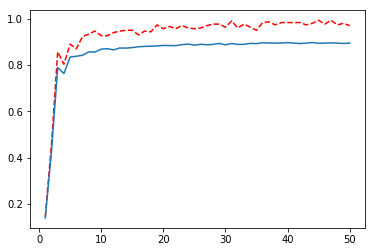

In [23]:
if __name__ == "__main__":
    main()